In [2]:
!pip install torchmetrics
!pip install segmentation-models-pytorch

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import tifffile as tiff
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import pearsonr
from torchmetrics.classification import BinaryJaccardIndex, BinaryAccuracy

## 3. Load and Normalize Data (Channel-Wise Normalization)

We need to normalize images ONLY. The masks are already normalized.


In [4]:
dataset_dir = '/kaggle/input/satalite-image/data/'

imgs_dir = os.path.join(dataset_dir, 'images')
msks_dir = os.path.join(dataset_dir, 'labels')

# --- Step 1: Match images and masks by filename ---
img_files = os.listdir(imgs_dir)
msk_files = os.listdir(msks_dir)

# Strip extensions → map IDs to files
img_ids = {os.path.splitext(f)[0]: f for f in img_files}
msk_ids = {os.path.splitext(f)[0]: f for f in msk_files}

# Only keep IDs that exist in BOTH sets
common_ids = sorted(set(img_ids.keys()) & set(msk_ids.keys()))

# Build aligned paths
images_paths = [os.path.join(imgs_dir, img_ids[i]) for i in common_ids]
masks_paths  = [os.path.join(msks_dir, msk_ids[i]) for i in common_ids]

print(f"Matched {len(images_paths)} image–mask pairs.")

# --- Step 2: Load data ---
images = np.array([tiff.imread(img).astype(np.float32) for img in images_paths])
masks = np.array([np.array(Image.open(msk).convert("L")) for msk in masks_paths])

# Expand mask dims (H, W, 1)
if masks.ndim == 3:
    masks = np.expand_dims(masks, axis=-1)

# --- Step 3: Normalize each channel ---
normalized_images = np.empty_like(images)
for ch in range(images.shape[-1]):
    ch_data = images[:, :, :, ch]
    ch_min, ch_max = np.min(ch_data), np.max(ch_data)
    normalized_images[:, :, :, ch] = (ch_data - ch_min) / (ch_max - ch_min)

print(f"Number of Images: {len(normalized_images)} - Shape: {normalized_images[0].shape}")
print(f"Number of Masks: {len(masks)} - Shape: {masks[0].shape}")

Matched 306 image–mask pairs.
Number of Images: 306 - Shape: (128, 128, 12)
Number of Masks: 306 - Shape: (128, 128, 1)


## 4. Visualize Correlation Matrix between Images Channels and Masks

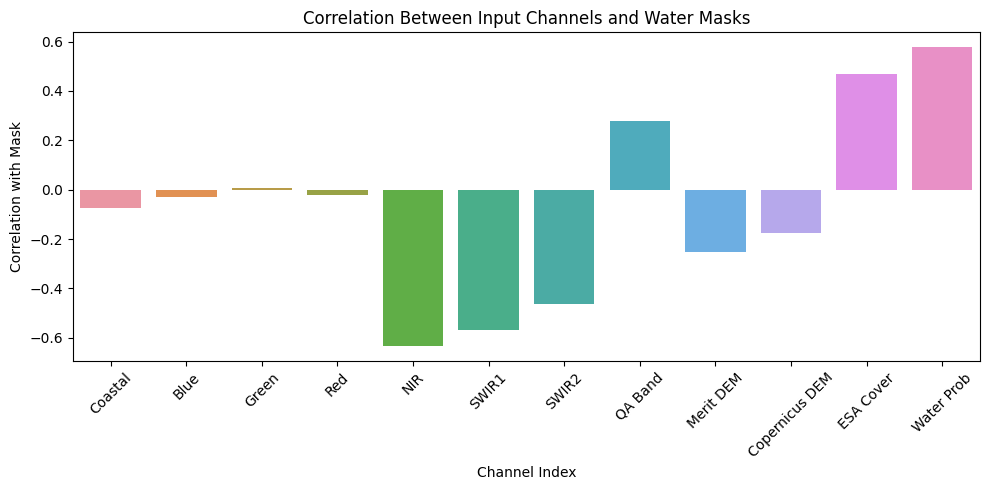

In [5]:
def correlation_matrix(images, masks, channels):
    num_channels = images.shape[-1]
    X = images.reshape(-1, num_channels)   # (N*H*W, C)
    y = masks.reshape(-1)                  # (N*H*W,)

    # Pearson correlation per channel
    correlations = [pearsonr(X[:, i], y)[0] for i in range(num_channels)]

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=np.arange(num_channels), y=correlations)
    plt.xlabel("Channel Index")
    plt.ylabel("Correlation with Mask")
    plt.title("Correlation Between Input Channels and Water Masks")
    plt.xticks(np.arange(num_channels), channels, rotation=45)
    plt.tight_layout()
    plt.show()

# --- Step 5: Run correlation ---
channels = [
    'Coastal', 'Blue', 'Green', 'Red', 'NIR', 
    'SWIR1', 'SWIR2', 'QA Band', 'Merit DEM', 
    'Copernicus DEM', 'ESA Cover', 'Water Prob'
]

correlation_matrix(normalized_images, masks, channels)

##  5. Feature Engineering and Correlation Matrix

Remove the least correlated channels to the masks and trying to generate new channels that will be highly correlated to the masks.


Final Image Shape: (128, 128, 11)


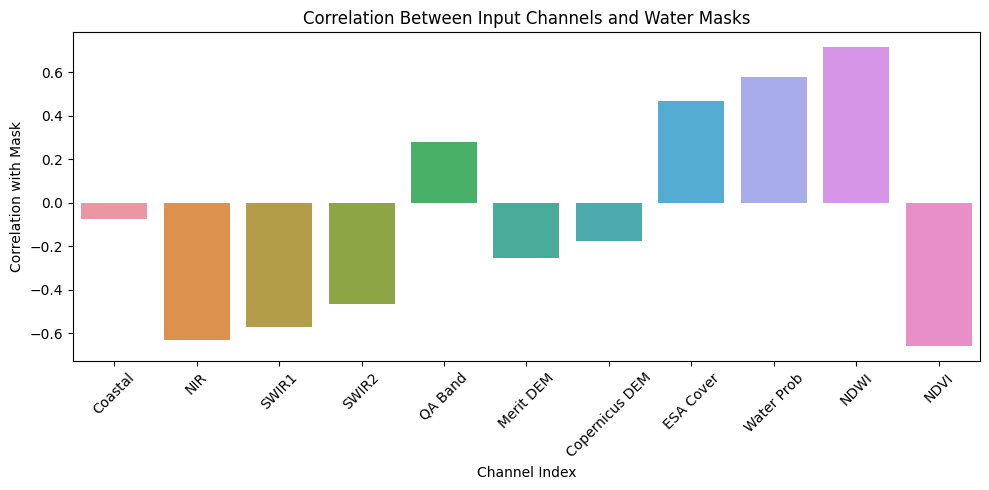

In [6]:
# Extract Some Channels
# We also could use (e.g. green = normalized_images[:,:,:,2])
red = normalized_images[...,3]
nir = normalized_images[...,4]
green = normalized_images[...,2]


# Generate new channels
# NDWI — Normalized Difference Water Index
ndwi = (green - nir) / (green + nir + 1e-9)

# NDVI — Vegetation Index (can help distinguish land from water)
ndvi = (nir - red) / (nir + red + 1e-9)

# Expand Dimensions to add as channels
ndwi = np.expand_dims(ndwi, axis=-1)
ndvi = np.expand_dims(ndvi, axis=-1)

# Add the new generated channels to the images
featured_images = np.concatenate([normalized_images, ndwi, ndvi], axis=-1)

# Remove the least important channels (Blue [1], Green [2], Red [3])
channels_to_remove = [1,2,3]
featured_images = np.delete(featured_images, obj=channels_to_remove, axis=-1)

# Show the new shape of the images (featured images)
print("Final Image Shape:", featured_images[0].shape)

# Show the correlation matrix after adding the new channels
new_channels = ['Coastal', 'NIR', 'SWIR1', 'SWIR2', 'QA Band', 'Merit DEM',
                'Copernicus DEM', 'ESA Cover', 'Water Prob', 'NDWI', 'NDVI']
correlation_matrix(images= featured_images, masks= masks, channels= new_channels)

## 6. Split the Data into Train/Validation/Test Splits

In [7]:
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(featured_images, masks, test_size=0.2, shuffle=True, random_state=42)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(temp_imgs, temp_masks, test_size=0.5, shuffle=False, random_state=42)

print("Train:", len(train_imgs))
print("Validation:", len(val_imgs))
print("Test:", len(test_imgs))

Train: 244
Validation: 31
Test: 31


## 7. Creating Datasets and Applying Augmentation

In [8]:
class WaterDataset(Dataset):
    def __init__(self, images, masks, augment=None):
        self.images = images
        self.masks = masks
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.augment:
            augmented = self.augment(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            mask = mask.permute(2, 0, 1) 
        return image, mask
    
train_aug = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomRotate90(),
    ToTensorV2()
])

test_val_aug = A.Compose([
    ToTensorV2()
])

train_dataset = WaterDataset(train_imgs, train_masks, augment=train_aug)
val_dataset = WaterDataset(val_imgs, val_masks, augment=test_val_aug)
test_dataset = WaterDataset(test_imgs, test_masks, augment=test_val_aug)

## 8. DataLoaders with Reproducibility

In [9]:
BATCH_SIZE = 16
SEED = 42
g = torch.Generator().manual_seed(SEED)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 9. Visualize Some Augmented Training Samples

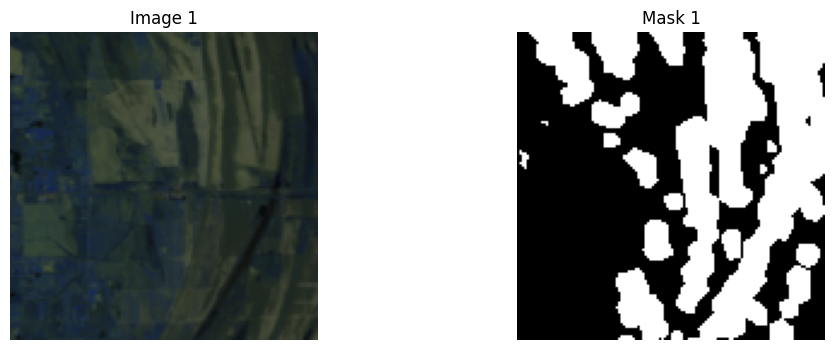

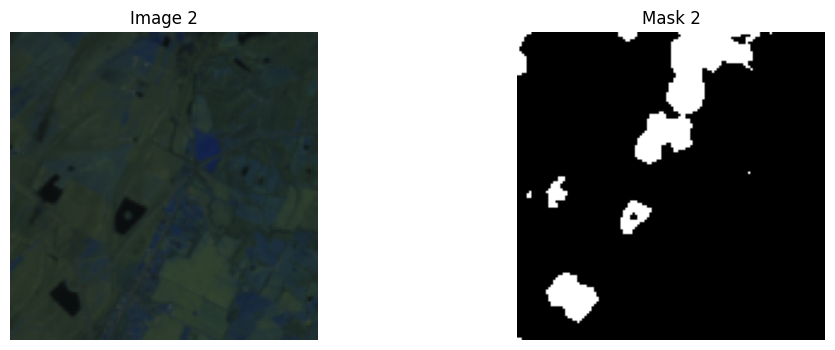

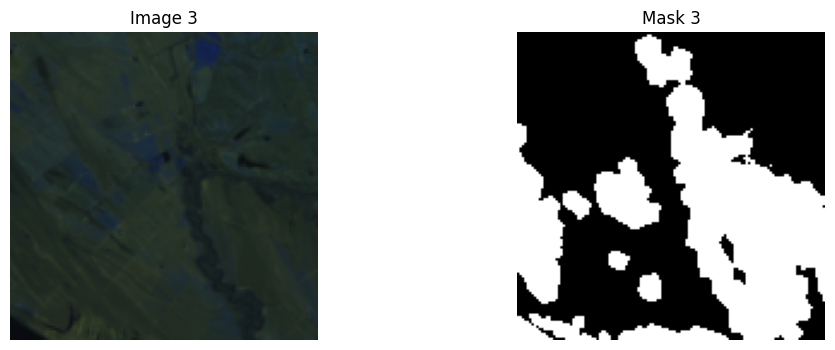

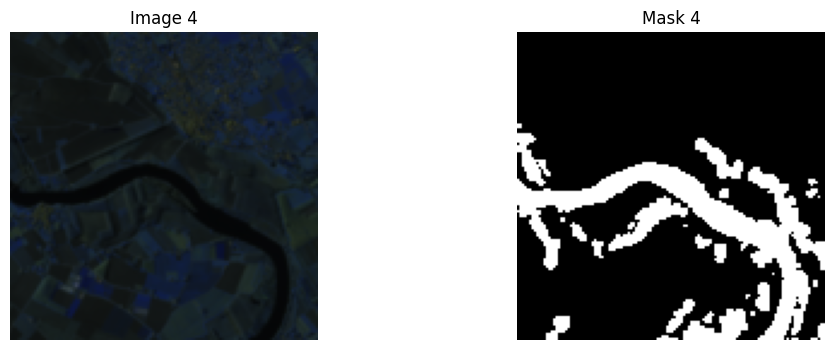

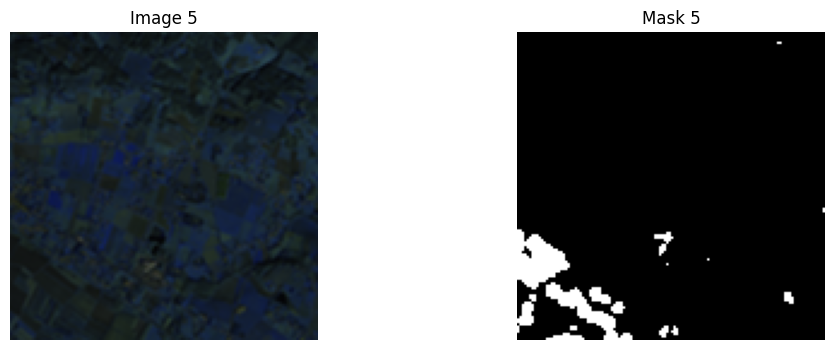

In [10]:
for img_batch, mask_batch in train_loader:
    # Plot 5 samples
    for i in range(5):
        img = img_batch[i].permute(1, 2, 0).cpu().numpy()
        mask = mask_batch[i].squeeze().cpu().numpy()

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img[..., [3, 2, 1]])  # Use bands 3, 2, 1 for NIR, SWIR1, SWIR2
        plt.title(f"Image {i+1}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis("off")

        plt.show()
    break

## Modeling


### 1. Build Model (UNet + MobileNetV2 Encoder)

In [11]:
model = smp.Unet(
    encoder_name='mobilenet_v2',
    encoder_weights='imagenet',
    in_channels=11,
    classes=1,
    activation=None
)

### 2. Define Loss and Optimizer

In [12]:
from torchinfo import summary
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()

def combined_loss(preds, targets):
    return 0.5 * dice_loss(preds, targets) + 0.5 * bce_loss(preds, targets)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, input_size=(1, 11, 256, 256), depth=3)

Layer (type:depth-idx)                                  Output Shape              Param #
Unet                                                    [1, 1, 256, 256]          --
├─MobileNetV2Encoder: 1-1                               [1, 11, 256, 256]         --
│    └─Sequential: 2-1                                  --                        --
│    │    └─Conv2dNormActivation: 3-1                   [1, 32, 128, 128]         3,232
│    │    └─InvertedResidual: 3-2                       [1, 16, 128, 128]         896
│    │    └─InvertedResidual: 3-3                       [1, 24, 64, 64]           5,136
│    │    └─InvertedResidual: 3-4                       [1, 24, 64, 64]           8,832
│    │    └─InvertedResidual: 3-5                       [1, 32, 32, 32]           10,000
│    │    └─InvertedResidual: 3-6                       [1, 32, 32, 32]           14,848
│    │    └─InvertedResidual: 3-7                       [1, 32, 32, 32]           14,848
│    │    └─InvertedResidual: 3-8     

### 3. Training Loop

In [13]:
def train_one_epoch(loader):
    model.train()
    running_loss = 0.0
    total_iou = 0.0
    total_acc = 0.0
    count = 0
    for images, masks in tqdm(loader):
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.sigmoid(outputs) > 0.5
        total_iou += iou_metric(preds.int(), masks.int()).item()
        total_acc += acc_metric(preds.int(), masks.int()).item()
        running_loss += loss.item()
        count += 1

    avg_loss = running_loss / count
    avg_iou = total_iou / count
    avg_acc = total_acc / count
    return avg_loss, avg_iou, avg_acc

### 4. Evaluation Funtion (Accuracy and IoU)

In [14]:
iou_metric = BinaryJaccardIndex().to(device)
acc_metric = BinaryAccuracy().to(device)

def evaluate(loader):
    model.eval()
    total_iou = 0.0
    total_acc = 0.0
    running_loss = 0.0
    count = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device, dtype=torch.float)
            masks = masks.to(device, dtype=torch.float)

            outputs = model(images)
            loss = combined_loss(outputs, masks)
            
            preds = torch.sigmoid(outputs) > 0.5
            total_iou += iou_metric(preds.int(), masks.int()).item()
            total_acc += acc_metric(preds.int(), masks.int()).item()
            running_loss += loss.item()
            count += 1

    avg_iou = total_iou / count
    avg_acc = total_acc / count
    avg_loss = running_loss / count
    return avg_iou, avg_acc, avg_loss

### 5. Train Model

In [15]:
EPOCHS = 100
best_val_iou = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_ious = []
val_ious = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_loss, train_iou, train_acc = train_one_epoch(train_loader)
    val_iou, val_acc, val_loss = evaluate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train IoU: {train_iou:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val IoU:   {val_iou:.4f} | Val Acc:   {val_acc:.4f}")

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved.")


Epoch 1/100


100%|██████████| 16/16 [00:01<00:00, 10.12it/s]


Train IoU: 0.4674 | Train Acc: 0.7038
Val IoU:   0.2416 | Val Acc:   0.8178
✅ Best model saved.

Epoch 2/100


100%|██████████| 16/16 [00:01<00:00, 15.07it/s]


Train IoU: 0.6446 | Train Acc: 0.8939
Val IoU:   0.4208 | Val Acc:   0.8785
✅ Best model saved.

Epoch 3/100


100%|██████████| 16/16 [00:01<00:00, 14.62it/s]


Train IoU: 0.6480 | Train Acc: 0.8891
Val IoU:   0.5318 | Val Acc:   0.9102
✅ Best model saved.

Epoch 4/100


100%|██████████| 16/16 [00:01<00:00, 15.04it/s]


Train IoU: 0.6588 | Train Acc: 0.8991
Val IoU:   0.5348 | Val Acc:   0.9061
✅ Best model saved.

Epoch 5/100


100%|██████████| 16/16 [00:01<00:00, 15.17it/s]


Train IoU: 0.6582 | Train Acc: 0.8985
Val IoU:   0.5498 | Val Acc:   0.9114
✅ Best model saved.

Epoch 6/100


100%|██████████| 16/16 [00:01<00:00, 14.86it/s]


Train IoU: 0.6717 | Train Acc: 0.9058
Val IoU:   0.5454 | Val Acc:   0.9119

Epoch 7/100


100%|██████████| 16/16 [00:01<00:00, 14.96it/s]


Train IoU: 0.6785 | Train Acc: 0.9059
Val IoU:   0.5715 | Val Acc:   0.9148
✅ Best model saved.

Epoch 8/100


100%|██████████| 16/16 [00:01<00:00, 14.89it/s]


Train IoU: 0.6760 | Train Acc: 0.9059
Val IoU:   0.5833 | Val Acc:   0.9152
✅ Best model saved.

Epoch 9/100


100%|██████████| 16/16 [00:01<00:00, 14.96it/s]


Train IoU: 0.6717 | Train Acc: 0.9018
Val IoU:   0.5513 | Val Acc:   0.9120

Epoch 10/100


100%|██████████| 16/16 [00:01<00:00, 14.81it/s]


Train IoU: 0.6608 | Train Acc: 0.8906
Val IoU:   0.3740 | Val Acc:   0.8064

Epoch 11/100


100%|██████████| 16/16 [00:01<00:00, 14.73it/s]


Train IoU: 0.6549 | Train Acc: 0.9020
Val IoU:   0.5553 | Val Acc:   0.9126

Epoch 12/100


100%|██████████| 16/16 [00:01<00:00, 15.15it/s]


Train IoU: 0.6999 | Train Acc: 0.9122
Val IoU:   0.5694 | Val Acc:   0.9154

Epoch 13/100


100%|██████████| 16/16 [00:01<00:00, 14.99it/s]


Train IoU: 0.6896 | Train Acc: 0.9105
Val IoU:   0.5535 | Val Acc:   0.9136

Epoch 14/100


100%|██████████| 16/16 [00:01<00:00, 15.08it/s]


Train IoU: 0.6689 | Train Acc: 0.9052
Val IoU:   0.5611 | Val Acc:   0.9142

Epoch 15/100


100%|██████████| 16/16 [00:01<00:00, 15.20it/s]


Train IoU: 0.6734 | Train Acc: 0.9092
Val IoU:   0.5553 | Val Acc:   0.9136

Epoch 16/100


100%|██████████| 16/16 [00:01<00:00, 15.11it/s]


Train IoU: 0.6952 | Train Acc: 0.9122
Val IoU:   0.5669 | Val Acc:   0.9155

Epoch 17/100


100%|██████████| 16/16 [00:01<00:00, 15.06it/s]


Train IoU: 0.6691 | Train Acc: 0.9037
Val IoU:   0.5596 | Val Acc:   0.9162

Epoch 18/100


100%|██████████| 16/16 [00:01<00:00, 15.16it/s]


Train IoU: 0.6878 | Train Acc: 0.9091
Val IoU:   0.6242 | Val Acc:   0.9198
✅ Best model saved.

Epoch 19/100


100%|██████████| 16/16 [00:01<00:00, 15.30it/s]


Train IoU: 0.6852 | Train Acc: 0.9084
Val IoU:   0.5522 | Val Acc:   0.9145

Epoch 20/100


100%|██████████| 16/16 [00:01<00:00, 15.02it/s]


Train IoU: 0.6788 | Train Acc: 0.9056
Val IoU:   0.5788 | Val Acc:   0.9167

Epoch 21/100


100%|██████████| 16/16 [00:01<00:00, 15.01it/s]


Train IoU: 0.6847 | Train Acc: 0.9085
Val IoU:   0.6227 | Val Acc:   0.9229

Epoch 22/100


100%|██████████| 16/16 [00:01<00:00, 15.16it/s]


Train IoU: 0.6602 | Train Acc: 0.9002
Val IoU:   0.6587 | Val Acc:   0.9282
✅ Best model saved.

Epoch 23/100


100%|██████████| 16/16 [00:01<00:00, 15.16it/s]


Train IoU: 0.6465 | Train Acc: 0.8994
Val IoU:   0.5681 | Val Acc:   0.9160

Epoch 24/100


100%|██████████| 16/16 [00:01<00:00, 14.96it/s]


Train IoU: 0.6974 | Train Acc: 0.9129
Val IoU:   0.5777 | Val Acc:   0.9177

Epoch 25/100


100%|██████████| 16/16 [00:01<00:00, 15.24it/s]


Train IoU: 0.6975 | Train Acc: 0.9122
Val IoU:   0.5670 | Val Acc:   0.9163

Epoch 26/100


100%|██████████| 16/16 [00:01<00:00, 15.30it/s]


Train IoU: 0.6503 | Train Acc: 0.8927
Val IoU:   0.6407 | Val Acc:   0.9237

Epoch 27/100


100%|██████████| 16/16 [00:01<00:00, 14.95it/s]


Train IoU: 0.6882 | Train Acc: 0.9133
Val IoU:   0.6859 | Val Acc:   0.9338
✅ Best model saved.

Epoch 28/100


100%|██████████| 16/16 [00:01<00:00, 14.88it/s]


Train IoU: 0.7116 | Train Acc: 0.9137
Val IoU:   0.5967 | Val Acc:   0.9227

Epoch 29/100


100%|██████████| 16/16 [00:01<00:00, 14.57it/s]


Train IoU: 0.6711 | Train Acc: 0.9076
Val IoU:   0.7007 | Val Acc:   0.9366
✅ Best model saved.

Epoch 30/100


100%|██████████| 16/16 [00:01<00:00, 14.97it/s]


Train IoU: 0.6970 | Train Acc: 0.9103
Val IoU:   0.6646 | Val Acc:   0.9318

Epoch 31/100


100%|██████████| 16/16 [00:01<00:00, 14.93it/s]


Train IoU: 0.7114 | Train Acc: 0.9160
Val IoU:   0.6810 | Val Acc:   0.9357

Epoch 32/100


100%|██████████| 16/16 [00:01<00:00, 14.90it/s]


Train IoU: 0.6908 | Train Acc: 0.9097
Val IoU:   0.6974 | Val Acc:   0.9389

Epoch 33/100


100%|██████████| 16/16 [00:01<00:00, 14.98it/s]


Train IoU: 0.7311 | Train Acc: 0.9219
Val IoU:   0.7256 | Val Acc:   0.9431
✅ Best model saved.

Epoch 34/100


100%|██████████| 16/16 [00:01<00:00, 14.95it/s]


Train IoU: 0.7300 | Train Acc: 0.9198
Val IoU:   0.6989 | Val Acc:   0.9393

Epoch 35/100


100%|██████████| 16/16 [00:01<00:00, 15.08it/s]


Train IoU: 0.7291 | Train Acc: 0.9198
Val IoU:   0.6779 | Val Acc:   0.9377

Epoch 36/100


100%|██████████| 16/16 [00:01<00:00, 14.96it/s]


Train IoU: 0.7058 | Train Acc: 0.9144
Val IoU:   0.7118 | Val Acc:   0.9406

Epoch 37/100


100%|██████████| 16/16 [00:01<00:00, 14.98it/s]


Train IoU: 0.7146 | Train Acc: 0.9165
Val IoU:   0.5862 | Val Acc:   0.9213

Epoch 38/100


100%|██████████| 16/16 [00:01<00:00, 14.77it/s]


Train IoU: 0.7269 | Train Acc: 0.9173
Val IoU:   0.7000 | Val Acc:   0.9404

Epoch 39/100


100%|██████████| 16/16 [00:01<00:00, 15.03it/s]


Train IoU: 0.7235 | Train Acc: 0.9201
Val IoU:   0.6654 | Val Acc:   0.9340

Epoch 40/100


100%|██████████| 16/16 [00:01<00:00, 14.99it/s]


Train IoU: 0.7459 | Train Acc: 0.9241
Val IoU:   0.6963 | Val Acc:   0.9386

Epoch 41/100


100%|██████████| 16/16 [00:01<00:00, 14.88it/s]


Train IoU: 0.7417 | Train Acc: 0.9227
Val IoU:   0.6073 | Val Acc:   0.9218

Epoch 42/100


100%|██████████| 16/16 [00:01<00:00, 14.97it/s]


Train IoU: 0.7355 | Train Acc: 0.9226
Val IoU:   0.7203 | Val Acc:   0.9428

Epoch 43/100


100%|██████████| 16/16 [00:01<00:00, 15.16it/s]


Train IoU: 0.7230 | Train Acc: 0.9188
Val IoU:   0.6653 | Val Acc:   0.9324

Epoch 44/100


100%|██████████| 16/16 [00:01<00:00, 15.04it/s]


Train IoU: 0.7116 | Train Acc: 0.9155
Val IoU:   0.6845 | Val Acc:   0.9390

Epoch 45/100


100%|██████████| 16/16 [00:01<00:00, 15.00it/s]


Train IoU: 0.7485 | Train Acc: 0.9260
Val IoU:   0.7205 | Val Acc:   0.9452

Epoch 46/100


100%|██████████| 16/16 [00:01<00:00, 14.85it/s]


Train IoU: 0.7387 | Train Acc: 0.9248
Val IoU:   0.6987 | Val Acc:   0.9408

Epoch 47/100


100%|██████████| 16/16 [00:01<00:00, 15.14it/s]


Train IoU: 0.7426 | Train Acc: 0.9237
Val IoU:   0.7338 | Val Acc:   0.9456
✅ Best model saved.

Epoch 48/100


100%|██████████| 16/16 [00:01<00:00, 15.18it/s]


Train IoU: 0.7384 | Train Acc: 0.9244
Val IoU:   0.7139 | Val Acc:   0.9440

Epoch 49/100


100%|██████████| 16/16 [00:01<00:00, 14.96it/s]


Train IoU: 0.7530 | Train Acc: 0.9273
Val IoU:   0.7378 | Val Acc:   0.9452
✅ Best model saved.

Epoch 50/100


100%|██████████| 16/16 [00:01<00:00, 15.03it/s]


Train IoU: 0.7528 | Train Acc: 0.9261
Val IoU:   0.7261 | Val Acc:   0.9463

Epoch 51/100


100%|██████████| 16/16 [00:01<00:00, 14.82it/s]


Train IoU: 0.7578 | Train Acc: 0.9276
Val IoU:   0.6918 | Val Acc:   0.9396

Epoch 52/100


100%|██████████| 16/16 [00:01<00:00, 15.22it/s]


Train IoU: 0.7561 | Train Acc: 0.9298
Val IoU:   0.6865 | Val Acc:   0.9395

Epoch 53/100


100%|██████████| 16/16 [00:01<00:00, 15.04it/s]


Train IoU: 0.7556 | Train Acc: 0.9288
Val IoU:   0.7423 | Val Acc:   0.9476
✅ Best model saved.

Epoch 54/100


100%|██████████| 16/16 [00:01<00:00, 15.20it/s]


Train IoU: 0.7521 | Train Acc: 0.9294
Val IoU:   0.7220 | Val Acc:   0.9449

Epoch 55/100


100%|██████████| 16/16 [00:01<00:00, 14.68it/s]


Train IoU: 0.7675 | Train Acc: 0.9322
Val IoU:   0.7465 | Val Acc:   0.9462
✅ Best model saved.

Epoch 56/100


100%|██████████| 16/16 [00:01<00:00, 15.04it/s]


Train IoU: 0.7482 | Train Acc: 0.9294
Val IoU:   0.7515 | Val Acc:   0.9488
✅ Best model saved.

Epoch 57/100


100%|██████████| 16/16 [00:01<00:00, 14.85it/s]


Train IoU: 0.7498 | Train Acc: 0.9292
Val IoU:   0.7309 | Val Acc:   0.9473

Epoch 58/100


100%|██████████| 16/16 [00:01<00:00, 14.95it/s]


Train IoU: 0.7834 | Train Acc: 0.9359
Val IoU:   0.7259 | Val Acc:   0.9446

Epoch 59/100


100%|██████████| 16/16 [00:01<00:00, 15.01it/s]


Train IoU: 0.7664 | Train Acc: 0.9317
Val IoU:   0.7232 | Val Acc:   0.9454

Epoch 60/100


100%|██████████| 16/16 [00:01<00:00, 14.90it/s]


Train IoU: 0.7804 | Train Acc: 0.9340
Val IoU:   0.7305 | Val Acc:   0.9467

Epoch 61/100


100%|██████████| 16/16 [00:01<00:00, 14.94it/s]


Train IoU: 0.7400 | Train Acc: 0.9230
Val IoU:   0.7206 | Val Acc:   0.9411

Epoch 62/100


100%|██████████| 16/16 [00:01<00:00, 14.83it/s]


Train IoU: 0.7059 | Train Acc: 0.9193
Val IoU:   0.7446 | Val Acc:   0.9479

Epoch 63/100


100%|██████████| 16/16 [00:01<00:00, 14.82it/s]


Train IoU: 0.7222 | Train Acc: 0.9246
Val IoU:   0.7364 | Val Acc:   0.9462

Epoch 64/100


100%|██████████| 16/16 [00:01<00:00, 15.03it/s]


Train IoU: 0.7385 | Train Acc: 0.9257
Val IoU:   0.7253 | Val Acc:   0.9422

Epoch 65/100


100%|██████████| 16/16 [00:01<00:00, 14.84it/s]


Train IoU: 0.7469 | Train Acc: 0.9285
Val IoU:   0.7196 | Val Acc:   0.9441

Epoch 66/100


100%|██████████| 16/16 [00:01<00:00, 14.87it/s]


Train IoU: 0.7575 | Train Acc: 0.9316
Val IoU:   0.7366 | Val Acc:   0.9478

Epoch 67/100


100%|██████████| 16/16 [00:01<00:00, 14.82it/s]


Train IoU: 0.7519 | Train Acc: 0.9341
Val IoU:   0.7153 | Val Acc:   0.9447

Epoch 68/100


100%|██████████| 16/16 [00:01<00:00, 15.26it/s]


Train IoU: 0.7628 | Train Acc: 0.9318
Val IoU:   0.7405 | Val Acc:   0.9473

Epoch 69/100


100%|██████████| 16/16 [00:01<00:00, 15.02it/s]


Train IoU: 0.7730 | Train Acc: 0.9337
Val IoU:   0.7343 | Val Acc:   0.9419

Epoch 70/100


100%|██████████| 16/16 [00:01<00:00, 15.01it/s]


Train IoU: 0.7723 | Train Acc: 0.9342
Val IoU:   0.7383 | Val Acc:   0.9485

Epoch 71/100


100%|██████████| 16/16 [00:01<00:00, 15.05it/s]


Train IoU: 0.7571 | Train Acc: 0.9300
Val IoU:   0.7504 | Val Acc:   0.9495

Epoch 72/100


100%|██████████| 16/16 [00:01<00:00, 14.73it/s]


Train IoU: 0.7674 | Train Acc: 0.9282
Val IoU:   0.7424 | Val Acc:   0.9489

Epoch 73/100


100%|██████████| 16/16 [00:01<00:00, 15.03it/s]


Train IoU: 0.7481 | Train Acc: 0.9243
Val IoU:   0.7447 | Val Acc:   0.9481

Epoch 74/100


100%|██████████| 16/16 [00:01<00:00, 15.11it/s]


Train IoU: 0.7709 | Train Acc: 0.9355
Val IoU:   0.7357 | Val Acc:   0.9475

Epoch 75/100


100%|██████████| 16/16 [00:01<00:00, 15.16it/s]


Train IoU: 0.7641 | Train Acc: 0.9320
Val IoU:   0.7088 | Val Acc:   0.9341

Epoch 76/100


100%|██████████| 16/16 [00:01<00:00, 15.28it/s]


Train IoU: 0.7610 | Train Acc: 0.9281
Val IoU:   0.7487 | Val Acc:   0.9489

Epoch 77/100


100%|██████████| 16/16 [00:01<00:00, 15.19it/s]


Train IoU: 0.7659 | Train Acc: 0.9300
Val IoU:   0.7180 | Val Acc:   0.9456

Epoch 78/100


100%|██████████| 16/16 [00:01<00:00, 15.09it/s]


Train IoU: 0.7687 | Train Acc: 0.9355
Val IoU:   0.7246 | Val Acc:   0.9464

Epoch 79/100


100%|██████████| 16/16 [00:01<00:00, 14.95it/s]


Train IoU: 0.7750 | Train Acc: 0.9338
Val IoU:   0.7423 | Val Acc:   0.9483

Epoch 80/100


100%|██████████| 16/16 [00:01<00:00, 14.99it/s]


Train IoU: 0.7559 | Train Acc: 0.9327
Val IoU:   0.7529 | Val Acc:   0.9505
✅ Best model saved.

Epoch 81/100


100%|██████████| 16/16 [00:01<00:00, 14.70it/s]


Train IoU: 0.7810 | Train Acc: 0.9317
Val IoU:   0.7574 | Val Acc:   0.9482
✅ Best model saved.

Epoch 82/100


100%|██████████| 16/16 [00:01<00:00, 14.92it/s]


Train IoU: 0.7637 | Train Acc: 0.9322
Val IoU:   0.7376 | Val Acc:   0.9468

Epoch 83/100


100%|██████████| 16/16 [00:01<00:00, 15.18it/s]


Train IoU: 0.7457 | Train Acc: 0.9154
Val IoU:   0.7176 | Val Acc:   0.9386

Epoch 84/100


100%|██████████| 16/16 [00:01<00:00, 14.94it/s]


Train IoU: 0.7401 | Train Acc: 0.9245
Val IoU:   0.6576 | Val Acc:   0.9327

Epoch 85/100


100%|██████████| 16/16 [00:01<00:00, 14.98it/s]


Train IoU: 0.7337 | Train Acc: 0.9260
Val IoU:   0.7197 | Val Acc:   0.9433

Epoch 86/100


100%|██████████| 16/16 [00:01<00:00, 15.03it/s]


Train IoU: 0.7441 | Train Acc: 0.9283
Val IoU:   0.7368 | Val Acc:   0.9416

Epoch 87/100


100%|██████████| 16/16 [00:01<00:00, 14.98it/s]


Train IoU: 0.7419 | Train Acc: 0.9327
Val IoU:   0.7321 | Val Acc:   0.9458

Epoch 88/100


100%|██████████| 16/16 [00:01<00:00, 14.73it/s]


Train IoU: 0.7563 | Train Acc: 0.9315
Val IoU:   0.7195 | Val Acc:   0.9394

Epoch 89/100


100%|██████████| 16/16 [00:01<00:00, 14.87it/s]


Train IoU: 0.7713 | Train Acc: 0.9321
Val IoU:   0.7146 | Val Acc:   0.9421

Epoch 90/100


100%|██████████| 16/16 [00:01<00:00, 14.62it/s]


Train IoU: 0.7665 | Train Acc: 0.9296
Val IoU:   0.6735 | Val Acc:   0.9388

Epoch 91/100


100%|██████████| 16/16 [00:01<00:00, 15.07it/s]


Train IoU: 0.7654 | Train Acc: 0.9304
Val IoU:   0.6078 | Val Acc:   0.9081

Epoch 92/100


100%|██████████| 16/16 [00:01<00:00, 15.01it/s]


Train IoU: 0.7546 | Train Acc: 0.9275
Val IoU:   0.7329 | Val Acc:   0.9453

Epoch 93/100


100%|██████████| 16/16 [00:01<00:00, 14.98it/s]


Train IoU: 0.7834 | Train Acc: 0.9362
Val IoU:   0.7017 | Val Acc:   0.9425

Epoch 94/100


100%|██████████| 16/16 [00:01<00:00, 15.10it/s]


Train IoU: 0.7626 | Train Acc: 0.9309
Val IoU:   0.7522 | Val Acc:   0.9486

Epoch 95/100


100%|██████████| 16/16 [00:01<00:00, 15.10it/s]


Train IoU: 0.7489 | Train Acc: 0.9272
Val IoU:   0.7472 | Val Acc:   0.9465

Epoch 96/100


100%|██████████| 16/16 [00:01<00:00, 14.88it/s]


Train IoU: 0.7510 | Train Acc: 0.9292
Val IoU:   0.7261 | Val Acc:   0.9414

Epoch 97/100


100%|██████████| 16/16 [00:01<00:00, 14.76it/s]


Train IoU: 0.7507 | Train Acc: 0.9269
Val IoU:   0.7557 | Val Acc:   0.9518

Epoch 98/100


100%|██████████| 16/16 [00:01<00:00, 14.92it/s]


Train IoU: 0.7688 | Train Acc: 0.9341
Val IoU:   0.7274 | Val Acc:   0.9401

Epoch 99/100


100%|██████████| 16/16 [00:01<00:00, 14.29it/s]


Train IoU: 0.7279 | Train Acc: 0.9173
Val IoU:   0.7647 | Val Acc:   0.9522
✅ Best model saved.

Epoch 100/100


100%|██████████| 16/16 [00:01<00:00, 14.86it/s]

Train IoU: 0.7636 | Train Acc: 0.9301
Val IoU:   0.6422 | Val Acc:   0.9328


## Evaluation

### 1. Test Model


In [16]:
model.load_state_dict(torch.load("best_model.pth"))
test_iou, test_acc, _ = evaluate(test_loader)

print(f"Test IoU: {test_iou:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}")

Test IoU: 0.8185
Test Accuracy: 94.70


### 2. Plot Train and Validation Metrics

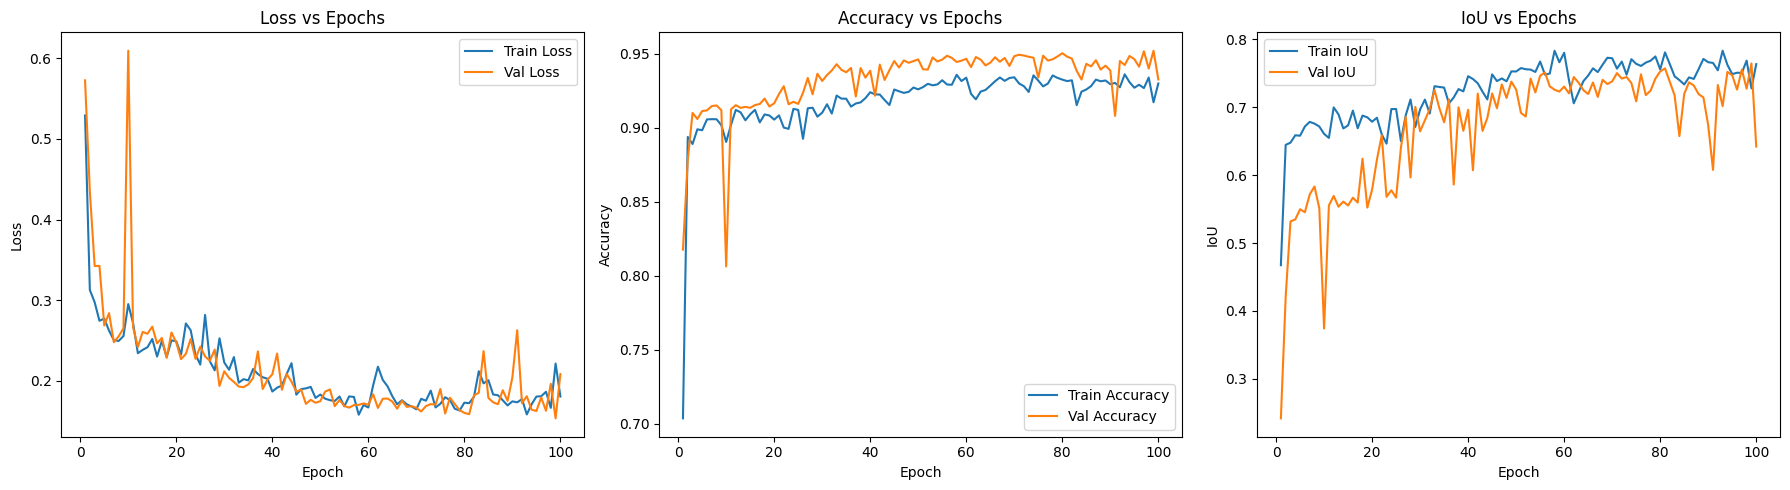

In [17]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(18, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

# IoU Plot
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_ious, label='Train IoU')
plt.plot(epochs_range, val_ious, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### 3. Visualize Model Predictions

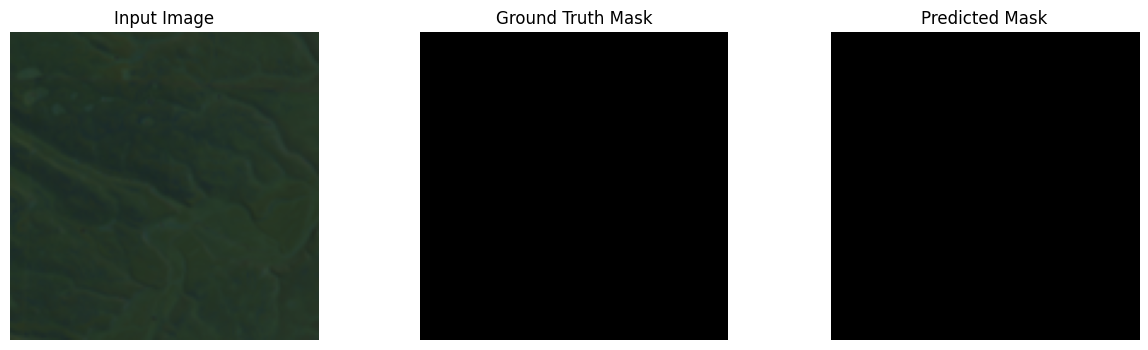

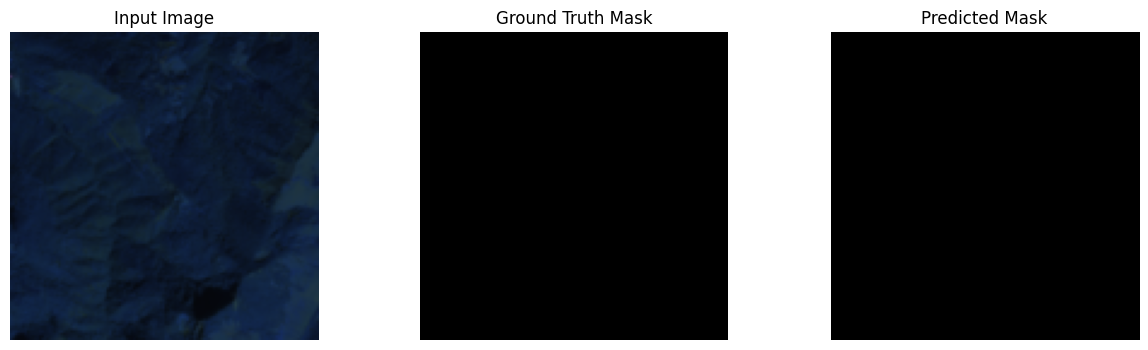

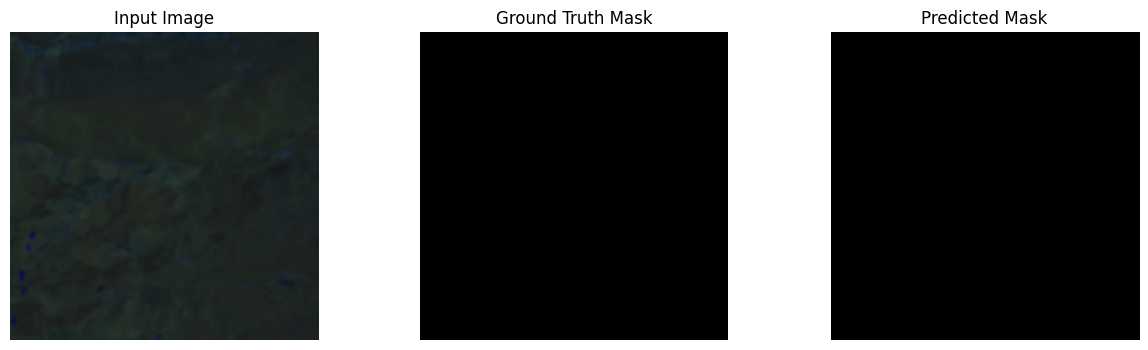

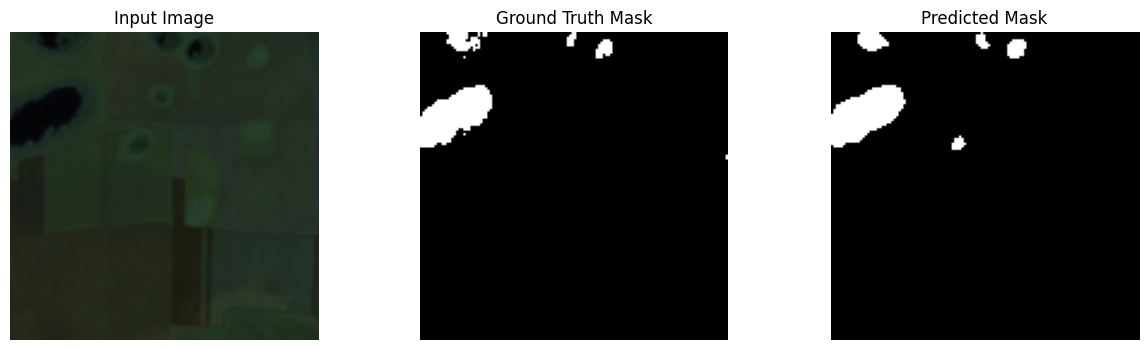

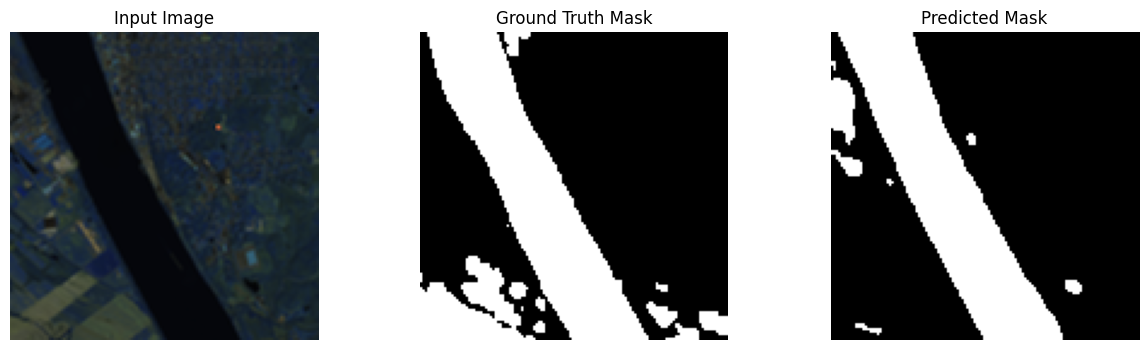

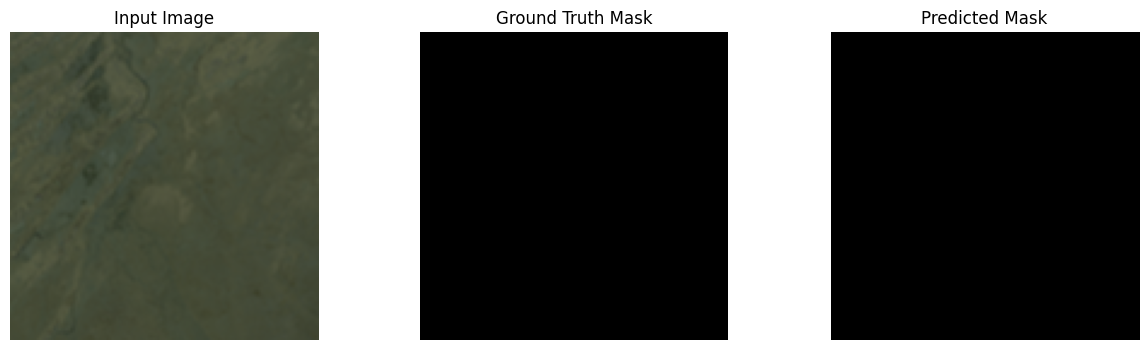

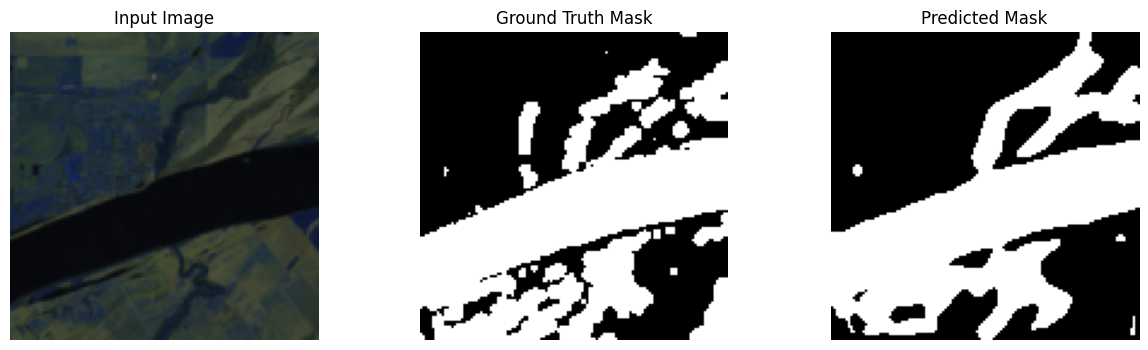

In [18]:
model.eval()

num_samples = 7
sample_loader = iter(test_loader)

images, masks = next(sample_loader)
images = images.to(device)
masks = masks.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = torch.sigmoid(outputs) > 0.5

for i in range(num_samples):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    gt = masks[i].squeeze().cpu().numpy()
    pred = preds[i].squeeze().cpu().numpy()

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img[..., [3, 2, 1]])  # NIR, SWIR1, SWIR2
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

### 4. Download Model


In [19]:
from IPython.display import FileLink

FileLink("best_model.pth")

/kaggle/working/best_model.pth